# SPY price direction prediction


Intraday ETF trading based on 10-sec aggregated equity market data.

#### Name :   < Xinyu Zhang >

## Data Set

SPY is an Exchange Traded Fund (ETF) that replicates the S&P 500 index, and trades in exchanges like ordinary equity.  
SPY is the most liquid (heavily traded) equity asset in the US.  

For all trading days in June 2018 we have aggregated in 10-sec intervals the trading activity in SPY across all exchanges.  
The dataset is provided in the file `Resources/Data/spy-10sec-201806.csv` at the class site.   
Each row corresponds to a specific 10-sec interval for the corresponding trading day.  
A row reports trading activity within the time period that *ends* at the corresponding interval.  

Regular trading hours in the US are from 09:30 to 16:00.  
You will notice that the 09:30 and 16:00 intervals have much larger traded volume relative to neighboring ones.  
This is because the market opens at 09:30 with an opening auction and closes at 16:00 with a closing auction.  
The consolidated limit order book is the collection of all quotes to buy (bid) and to sell (ask).  
Bid and ask prices/sizes are quotes, i.e. proposals to trade a given quantity at a given price.  
VWAP is the volume weighted average of prices at which trades actually occurred.  




|Column              | Description  |
---------------------|--------------|
|volume              | Number of shares traded within the interval  ($\sum_i V_i $,   summing over all trades $i$)          |
|vwap                | Volume Weighted Average Price ( $VWAP = \sum_i V_i P_i / \sum_i V_i$,   summing over all trades $i$) |
|lowPx/highPx        | Lowest and highest trade prices within the interval                               |
|lastBidPx/lastAskPx | Last bid and ask price in the interval                         |
|lastBidSz/lastAskSz | Last bid and ask sizes (in hundreds of shares) in the interval |


#### Feature engineering

Derived quantities of interest are

1. The Close Location Value (CLV) indicator. This is an intraday adaptation of a classic technical indicator. It is defined as  
$$
CLV_t = \frac{VWAP_t - (lowPx_t + highPx_t)/2}{(highPx_t - lowPx_t)/2}
$$
It measures the location of the VWAP within interval $t$, relative to the mid-point price between low and high price.  

2. The last *quote imbalance* of interval $t$, defined as 
$$
Imbal_t = \frac{lastBidSz_t - lastAskSz_t}{lastBidSz_t + lastAskSz_t}
$$
By construction $-1 \le Imbal \le 1$.  
When $Imbal \rightarrow 1$, there is much more interest to buy than to sell. 
Conversely, when $Imbal \rightarrow -1$ there is much more interest to sell than to buy.  

3. The log-transformed volume defined as $logVolume = log10(Volume)$  
When working with volume-like quantities (non-negative) taking logs is a common normalization.  
Either base 10 or natural logs can be used, base 10 logs may be easier to interpret.

We are also interested in the $N$-period forward return in basis points
$$
\mathrm{fwdRetNBps}_t = 10000 * \left(\frac{VWAP_{t+N}}{VWAP_t} - 1\right)
$$

## Problem (100 points)

#### Objective
+ Construct ML models that use features derived from market observables, to predict price direction in future periods
+ Assess the models using 10-sec as well as 1-min aggregation periods

#### Data Preparation (30 points)
+ Load the SPY 10-sec data
+ Calculate the CLV and the last quote imbalance for each interval. If highPx is equal to lowPx for an interval, set the CLV value to 0.
+ Calculate the 1-period forward VWAP returns in basis points
+ Split the dataset into training sample with the first 16 days, and testing sample with the remaining 4 trading days.
+ Use the average VWAP in the training set a reference price. Call this $\mathrm{RefPx}$.
+ Compute a cutoff return in basis points as:  $\mathrm{cutRetBps} = 10000 * (0.02) / \mathrm{RefPx}$  
  This return corresponds to VWAP movement of twice the typical bid-ask spread (i.e 2 * 0.01)
+ Add a new column called pxDir1 (price direction) and label the 1-period forward price movement as follows:  
  * If fwdRet1Bps > cutRetBps then pxDir1 = +1  
  * If abs(fwdRet1Bps) <= cutRetBps then pxDir1 = 0  
  * If fwdRet1Bps < - cutRet1Bps then pxDir1 = -1  
  Therefore pxDir is a class variable taking values in the set $\{-1, 0, 1\}$.
+ Re-aggregate the 10-sec data into 1-min data and store them in a new data frame.
+ Repeat the process above (CLV, quote imbalance, forward returns, price direction labeling) with the 1-min data.

#### Modeling (60 points)

+ Exploratory data analysis (EDA) which should contain:   
    * univariate distributions of features: logVolume, clv, imbalance  
    * univariate distributions of targets: fwdRet1Bps, pxDir1  
    * any other distribution that may reveal a relationship between target and features  
    * correlation heat map  
+ Construction of a *baseline* model, to be used as a reference.  
  The baseline model predicts the price direction class $C=\{-1, 0, 1\}$ randomly using the class empirical probability of occurence.  
$$
\mathbb{P}(C=\pm 1) = \frac{N_{train}(C=\pm 1)}{N_{train}}, \quad 
\mathbb{P}(C=0) = \frac{N_{train}(C=0)}{N_{train}}
$$
Estimate the empirical probabilities of the baseline model using the training set.  
Make predictions for pxDir1 (simply sample the multinomial distribution) and use the testing set to report  

|Model               | Accuracy  | Precision  | Recall | F1wght | F1micro | 
---------------------|-----------|------------|--------|---------|---------|
|Baseline            | ...       | ...        | ...    | ...     | ...     |

Precision, Recall and F1wght should be measured "weighted" to account for class occurence and potential imbalance.  
F1micro is the "micro" F1 score, i.e. it first computes total true/false positives/negatives first and then computes the F1 score.

+ Construct *two* models, of which one should be neural net based.  
  The other could be any of the classic ML models (Logistic, SVM, Forest, AdaBoost, ...)  
  Train and tune the models in order to forecast the target variable pxDir1.  
  Evaluate the models on the test sample and add their performance metrics to the table above.  
  
+ Reaggregate the data using 1-min intervals and repeat the model runs 

+ Present your conclusions about the best model on the 10-sec and 1-min aggregated data

#### Extra Improvement (10 points)

Attempt to improve model performance by introducing one extra feature variable, derived from the existing market data.  
The extra variable could be either some kind of moving average or an intraday adaptation of a technical indicator.  
Measure the performance improvement for the 10-sec and 1-min dataset.

#### Submission Format

* Follow the submission rules for homeworks.  
* The main document is this notebook, describing the methodology and the conclusions.  
* Make sure your notebook runs using the standard packages we used in class: numpy/scipy/sklearn/statsmodels/tensorflow/keras.
* You can write your own utility classes and functions in separate source code files and import them into this notebook.  
* Assume that your separate source code files will be side-by-side with the notebook. 
* If you are submitting multiple files, put them in a zip archive.

Good luck.


#  <table><tr><td bgcolor=orange> <font  color=#4B0082 size=5>  Solution  </font> </td></tr></table>

# <font color="#0000dd"> Introduction </font><br/>   

##  Contents:  
   - Data Preprocessing 
   
   
   - Feature Engineering
   
   
   - Visualization and Feature Correlation
   
   
   - Modeling the Data : 
       - Baseline Model
       - Logistic Regression
       - XGBClassifier
       - LSTM
       
           
   - Improvement
   
   
   - Conclusion

In [1]:
%matplotlib inline
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
np.random.seed(42)

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten, SimpleRNN, LSTM
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


# <font color="#0000dd"> Data Preprocessing </font><br/>   

In [2]:
datapath = './spy-10sec-201806.csv'
data_df = pd.read_csv(datapath)

In [3]:
data_df.head(5)

,date,time,sym,volume,vwap,lowPx,highPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz
0,2018-06-01,09:30:00,SPY,395424,272.459140,272.320007,272.489990,272.359985,272.380005,14,100
1,2018-06-01,09:30:10,SPY,55692,272.395593,272.339996,272.489990,272.399994,272.410004,9,50
2,2018-06-01,09:30:20,SPY,85164,272.443104,272.390015,272.470001,272.450012,272.459991,18,7
3,2018-06-01,09:30:30,SPY,26973,272.441112,272.420013,272.459991,272.429993,272.440002,5,20
4,2018-06-01,09:30:40,SPY,77809,272.440219,272.410004,272.480011,272.420013,272.429993,1,13


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46815 entries, 0 to 46814
Data columns (total 11 columns):
date         46815 non-null object
time         46815 non-null object
sym          46815 non-null object
volume       46815 non-null int64
vwap         46815 non-null float64
lowPx        46815 non-null float64
highPx       46815 non-null float64
lastBidPx    46815 non-null float64
lastAskPx    46815 non-null float64
lastBidSz    46815 non-null int64
lastAskSz    46815 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 3.9+ MB


In [5]:
data_df.describe()

,volume,vwap,lowPx,highPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz
count,4.681500e+04,46815.000000,46815.000000,46815.000000,46815.000000,46815.000000,46815.000000,46815.000000
mean,2.400354e+04,275.399784,275.379965,275.419552,275.394695,275.404879,35.313617,37.163388
std,9.759817e+04,2.692698,2.697995,2.687000,2.692326,2.692290,49.749158,69.750612
min,1.000000e+00,268.543764,268.489990,268.576202,268.510010,268.519989,1.000000,1.000000
25%,5.663500e+03,273.792457,273.769989,273.809998,273.779999,273.790009,4.000000,4.000000
50%,1.208900e+04,275.499918,275.484589,275.519989,275.489990,275.510010,10.000000,10.000000
75%,2.545500e+04,277.395100,277.375000,277.410004,277.390015,277.399994,50.000000,47.000000
max,1.570653e+07,279.471895,279.459991,279.480011,279.470001,279.480011,1825.000000,2721.000000


##  Get 10-sec data & 1-min aggregation periods data

In [6]:
data_df['T'] = pd.to_datetime(data_df['date']+' '+data_df['time'])
data_df['tempory']=data_df['vwap']*data_df['volume']

data_df.loc[data_df['time'] =='09:30:00',"ave_vwap"]=data_df.loc[data_df['time'] =='09:30:00',"vwap"]
data_df.loc[data_df['time'] !='09:30:00',"ave_vwap"]=data_df[data_df['time'] !='09:30:00']['tempory'].rolling(6).sum()/data_df[data_df['time'] !='09:30:00']['volume'].rolling(6).sum()

data_df.head()

,date,time,sym,volume,vwap,lowPx,highPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz,T,tempory,ave_vwap
0,2018-06-01,09:30:00,SPY,395424,272.459140,272.320007,272.489990,272.359985,272.380005,14,100,2018-06-01 09:30:00,1.077369e+08,272.45914
1,2018-06-01,09:30:10,SPY,55692,272.395593,272.339996,272.489990,272.399994,272.410004,9,50,2018-06-01 09:30:10,1.517026e+07,NaN
2,2018-06-01,09:30:20,SPY,85164,272.443104,272.390015,272.470001,272.450012,272.459991,18,7,2018-06-01 09:30:20,2.320234e+07,NaN
3,2018-06-01,09:30:30,SPY,26973,272.441112,272.420013,272.459991,272.429993,272.440002,5,20,2018-06-01 09:30:30,7.348554e+06,NaN
4,2018-06-01,09:30:40,SPY,77809,272.440219,272.410004,272.480011,272.420013,272.429993,1,13,2018-06-01 09:30:40,2.119830e+07,NaN


In [7]:
data_df.columns

Index(['date', 'time', 'sym', 'volume', 'vwap', 'lowPx', 'highPx', 'lastBidPx',
       'lastAskPx', 'lastBidSz', 'lastAskSz', 'T', 'tempory', 'ave_vwap'],
      dtype='object')

In [8]:
S_data=data_df[['date', 'time', 'sym', 'volume', 'vwap', 'lowPx', 'highPx', 'lastBidPx','lastAskPx', 'lastBidSz', 'lastAskSz', 'T', 'tempory']]
S_data=S_data.set_index(S_data['T'])
S_data.head()

,date,time,sym,volume,vwap,lowPx,highPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz,T,tempory
T,,,,,,,,,,,,,
2018-06-01 09:30:00,2018-06-01,09:30:00,SPY,395424,272.459140,272.320007,272.489990,272.359985,272.380005,14,100,2018-06-01 09:30:00,1.077369e+08
2018-06-01 09:30:10,2018-06-01,09:30:10,SPY,55692,272.395593,272.339996,272.489990,272.399994,272.410004,9,50,2018-06-01 09:30:10,1.517026e+07
2018-06-01 09:30:20,2018-06-01,09:30:20,SPY,85164,272.443104,272.390015,272.470001,272.450012,272.459991,18,7,2018-06-01 09:30:20,2.320234e+07
2018-06-01 09:30:30,2018-06-01,09:30:30,SPY,26973,272.441112,272.420013,272.459991,272.429993,272.440002,5,20,2018-06-01 09:30:30,7.348554e+06
2018-06-01 09:30:40,2018-06-01,09:30:40,SPY,77809,272.440219,272.410004,272.480011,272.420013,272.429993,1,13,2018-06-01 09:30:40,2.119830e+07


###  1-min aggregation periods data

In [9]:
# 1 minite Data
conversion = {'volume' : 'sum', 'lowPx' : 'min', 'highPx' : 'max', 'lastBidPx':'last','lastAskPx': 'last','lastBidSz':'last','lastAskSz':'last','ave_vwap':'last'}
M_data=data_df
M_data=M_data.set_index(M_data['T'])
M_data=M_data.resample('Min', how = conversion) 

In [10]:
M_data.head()

,volume,lowPx,highPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz,ave_vwap
T,,,,,,,,
2018-06-01 09:30:00,661687,272.320007,272.489990,272.440002,272.459991,100.0,37.0,272.459140
2018-06-01 09:31:00,360086,272.390015,272.559998,272.519989,272.529999,3.0,12.0,272.483874
2018-06-01 09:32:00,270282,272.470001,272.565002,272.470001,272.480011,1.0,19.0,272.513814
2018-06-01 09:33:00,311647,272.450012,272.529999,272.480011,272.489990,26.0,1.0,272.483097
2018-06-01 09:34:00,222903,272.489990,272.619995,272.609985,272.619995,100.0,50.0,272.557897


##  Feature Engineering

- Calculate the CLV and the last quote imbalance for each interval.
- Calculate logvolume (working with volume-like non-negative quantities).
- Calculate the 1-period forward VWAP returns in basis points
- Compare Respx and cutRetBps to get pxDir1 lable direction.

### Min Data

In [11]:

# Calculate the CLV and the last quote imbalance for each interval. If highPx is equal to lowPx for an interval, set the CLV value to 0.to 0.
M_data['CLV']=(M_data['ave_vwap']-(M_data['lowPx']+M_data['highPx'])/2)/((M_data['highPx']-M_data['lowPx'])/2)
M_data[M_data['highPx']==M_data['lowPx']]['CLV']=0
M_data['Imbal']=(M_data['lastBidSz']-M_data['lastAskSz'])/(M_data['lastBidSz']+M_data['lastAskSz'])
# logvolume
M_data['logVolume']=np.log10(M_data['volume'])
# Calculate the 1-period forward VWAP returns in basis points
M_data['fwdRet1Bps']=10000*(M_data['ave_vwap'].shift(-1)/M_data['ave_vwap']-1)
# Split train set to calculate Respx
M_train=M_data[M_data.index < np.datetime64('2018-06-23')]
# Use the average VWAP in the training set a reference price. Call this  RefPx
# Compute a cutoff return in basis points as:  cutRetBps=10000∗(0.02)/RefPx
M_RefPx=M_train['ave_vwap'].mean()
M_cutRetBps=10000*0.02/M_RefPx
# Lable Direction
M_data.loc[M_data['fwdRet1Bps']>M_cutRetBps,'pxDir1']=1
M_data.loc[abs(M_data['fwdRet1Bps'])<=M_cutRetBps,'pxDir1']=0
M_data.loc[M_data['fwdRet1Bps']<-M_cutRetBps,'pxDir1']=-1

M_data=M_data.replace([np.inf, -np.inf], np.nan)

M_data=M_data.dropna()
M_data.pxDir1=M_data.pxDir1.astype(int).astype(str)


In [12]:
M_data.head()

,volume,lowPx,highPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz,ave_vwap,CLV,Imbal,logVolume,fwdRet1Bps,pxDir1
T,,,,,,,,,,,,,
2018-06-01 09:30:00,661687,272.320007,272.489990,272.440002,272.459991,100.0,37.0,272.459140,0.637020,0.459854,5.820653,0.907802,1
2018-06-01 09:31:00,360086,272.390015,272.559998,272.519989,272.529999,3.0,12.0,272.483874,0.104338,-0.600000,5.556406,1.098780,1
2018-06-01 09:32:00,270282,272.470001,272.565002,272.470001,272.480011,1.0,19.0,272.513814,-0.077639,-0.900000,5.431817,-1.127159,-1
2018-06-01 09:33:00,311647,272.450012,272.529999,272.480011,272.489990,26.0,1.0,272.483097,-0.172733,0.925926,5.493663,2.745107,1
2018-06-01 09:34:00,222903,272.489990,272.619995,272.609985,272.619995,100.0,50.0,272.557897,0.044678,0.333333,5.348116,6.670272,1


### Sec Data

In [13]:

S_data=data_df
S_data=S_data.set_index(S_data['T'])
# Calculate the CLV and the last quote imbalance for each interval. If highPx is equal to lowPx for an interval, set the CLV value to 0.to 0.
S_data['CLV']=(S_data['vwap']-(S_data['lowPx']+S_data['highPx'])/2)/((S_data['highPx']-S_data['lowPx'])/2)
S_data[S_data['highPx']==S_data['lowPx']]['CLV']=0
S_data['Imbal']=(S_data['lastBidSz']-S_data['lastAskSz'])/(S_data['lastBidSz']+S_data['lastAskSz'])
# logvolume
S_data['logVolume']=np.log10(S_data['volume'])
# Calculate the 1-period forward VWAP returns in basis points
S_data['fwdRet1Bps']=10000*(S_data['vwap'].shift(-1)/S_data['vwap']-1)
# Split train set to calculate Respx
S_train=S_data[S_data.index < np.datetime64('2018-06-23')]
# Use the average VWAP in the training set a reference price. Call this  RefPx
# Compute a cutoff return in basis points as:  cutRetBps=10000∗(0.02)/RefPx
S_RefPx=S_train['vwap'].mean()
S_cutRetBps=10000*0.02/S_RefPx
# Lable Direction
S_data.loc[S_data['fwdRet1Bps']>S_cutRetBps,'pxDir1']=1
S_data.loc[abs(S_data['fwdRet1Bps'])<=S_cutRetBps,'pxDir1']=0
S_data.loc[S_data['fwdRet1Bps']<-S_cutRetBps,'pxDir1']=-1

S_data=S_data.replace([np.inf, -np.inf], np.nan)
S_data=S_data.drop(['ave_vwap'], axis=1).dropna()

S_data.pxDir1=S_data.pxDir1.astype(int).astype(str)
S_data.head()

,date,time,sym,volume,vwap,lowPx,highPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz,T,tempory,CLV,Imbal,logVolume,fwdRet1Bps,pxDir1
T,,,,,,,,,,,,,,,,,,
2018-06-01 09:30:00,2018-06-01,09:30:00,SPY,395424,272.459140,272.320007,272.489990,272.359985,272.380005,14,100,2018-06-01 09:30:00,1.077369e+08,0.637020,-0.754386,5.597063,-2.332345,-1
2018-06-01 09:30:10,2018-06-01,09:30:10,SPY,55692,272.395593,272.339996,272.489990,272.399994,272.410004,9,50,2018-06-01 09:30:10,1.517026e+07,-0.258679,-0.694915,4.745793,1.744181,1
2018-06-01 09:30:20,2018-06-01,09:30:20,SPY,85164,272.443104,272.390015,272.470001,272.450012,272.459991,18,7,2018-06-01 09:30:20,2.320234e+07,0.327454,0.440000,4.930256,-0.073097,0
2018-06-01 09:30:30,2018-06-01,09:30:30,SPY,26973,272.441112,272.420013,272.459991,272.429993,272.440002,5,20,2018-06-01 09:30:30,7.348554e+06,0.055529,-0.600000,4.430929,-0.032791,0
2018-06-01 09:30:40,2018-06-01,09:30:40,SPY,77809,272.440219,272.410004,272.480011,272.420013,272.429993,1,13,2018-06-01 09:30:40,2.119830e+07,-0.136794,-0.857143,4.891030,-0.013157,0


##  Train test split

- Split the dataset into training sample with the first 16 days, and testing sample with the remaining 4 trading days.

In [14]:
# SEC
S_train=S_data[S_data.index < '2018-06-23']
S_test=S_data[S_data.index> '2018-06-23']

S_train=S_train[['logVolume','CLV', 'Imbal','fwdRet1Bps', 'pxDir1']]
S_test=S_test[['logVolume', 'CLV', 'Imbal','fwdRet1Bps' ,'pxDir1']]

S_train_X=S_train.iloc[:,:-2]
S_train_y=S_train.iloc[:,-1]
S_test_X=S_test.iloc[:,:-2]
S_test_y=S_test.iloc[:,-1]

In [15]:
# MIN
M_train=M_data[M_data.index< '2018-06-23']
M_test=M_data[M_data.index > '2018-06-23']

M_train=M_train[['logVolume', 'CLV', 'Imbal' ,'fwdRet1Bps','pxDir1']]
M_test=M_test[['logVolume', 'CLV', 'Imbal','fwdRet1Bps','pxDir1']]

M_train_X=M_train.iloc[:,:-2]
M_train_y=M_train.iloc[:,-1]
M_test_X=M_test.iloc[:,:-2]
M_test_y=M_test.iloc[:,-1]

#  <font color="#0000dd"> Discover and Visualize Data to gain insights </font> <br/>   

## - Sec Data

### 1. Distribution of each features

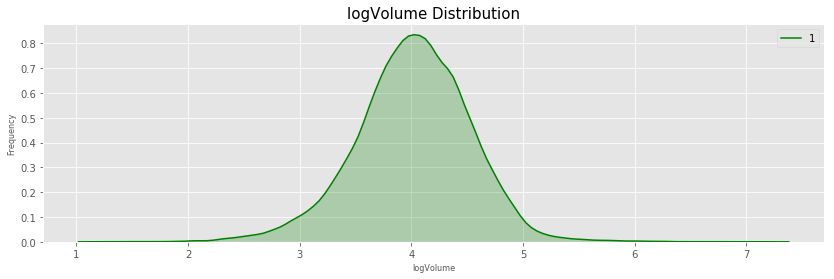

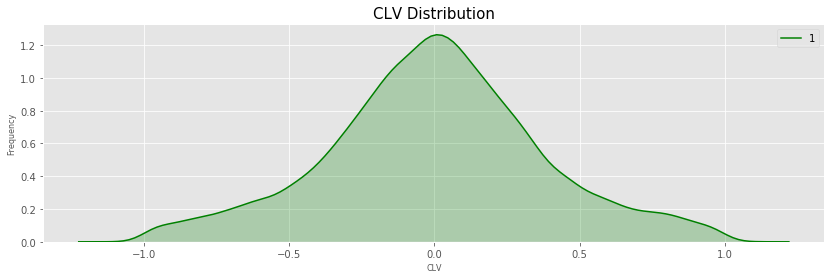

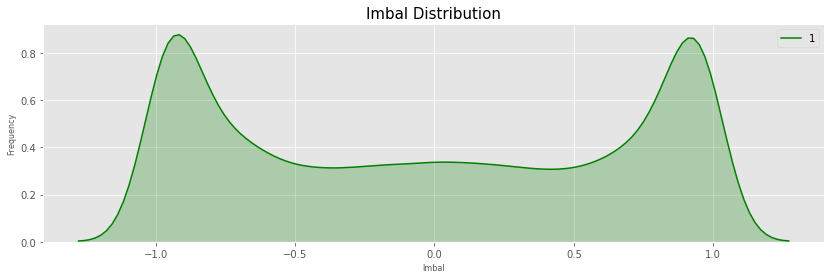

In [16]:
for col in ['logVolume','CLV', 'Imbal']:
    fig = plt.figure(figsize=(14,4));
    ax=sns.kdeplot(S_train.loc[:,col] , color='g',shade=True,label='1');
    plt.title(col+' Distribution', fontsize = 15);
    plt.ylabel("Frequency", fontsize = 8);
    plt.xlabel(col, fontsize = 8);

### 2. Distribution of fwdRet1Bps and pxDir1

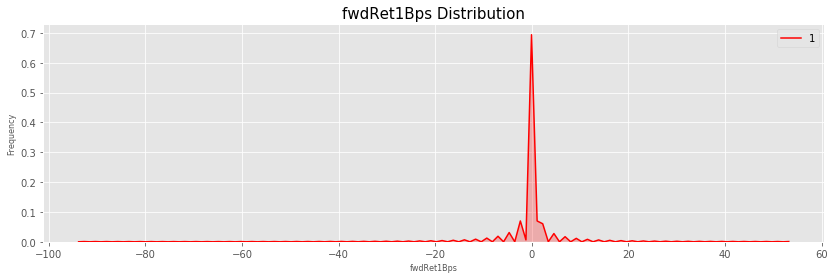

In [17]:
fig = plt.figure(figsize=(14,4));
ax=sns.kdeplot(S_train.loc[:,'fwdRet1Bps'] , color='r',shade=True,label='1');
plt.title('fwdRet1Bps'+' Distribution', fontsize = 15);
plt.ylabel("Frequency", fontsize = 8);
plt.xlabel('fwdRet1Bps', fontsize = 8);

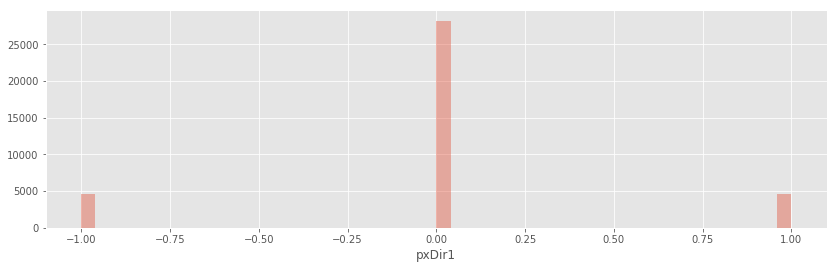

In [18]:
plt.figure(figsize=(14,4))
sns.distplot(S_train.pxDir1.astype(int),kde=False)

 - The data is highly imbalanced: We have 0 label far more than +1 and -1.


 - Unbalanced classes create two problems:
 
    - The accuracy is no longer a good measure of the model performance.   
      A model that just predicts 0 everytime will yield a good accuracy, even though it does nothing and meanless.
    - The training process might arrive at a local optimum that always predicts 0, making it hard to improve our model.


### 3. Feature distributions with different labels

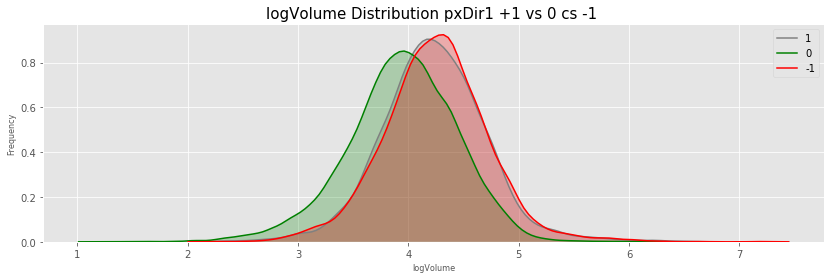

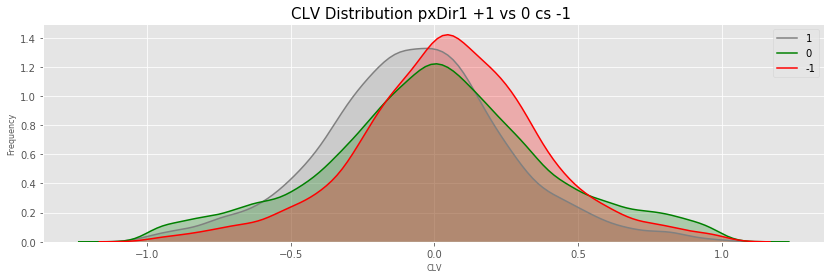

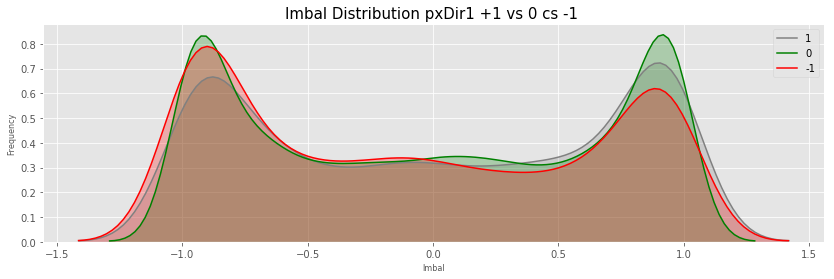

In [19]:
import seaborn as sns

for col in ['logVolume', 'CLV', 'Imbal']:
    fig = plt.figure(figsize=(14,4));
    ax=sns.kdeplot(S_train.loc[(S_train['pxDir1'] == '1'),col] , color='gray',shade=True,label='1');
    ax=sns.kdeplot(S_train.loc[(S_train['pxDir1'] == '0'),col] , color='g',shade=True, label='0');
    ax=sns.kdeplot(S_train.loc[(S_train['pxDir1'] == '-1'),col] , color='r',shade=True, label='-1')
    plt.title(col+' Distribution pxDir1 +1 vs 0 cs -1 ', fontsize = 15);
    plt.ylabel("Frequency", fontsize = 8);
    plt.xlabel(col, fontsize = 8);

### 4. Correlation heat map

- Below shows the heatmap of feature correlation matrix.
- we can find our features don't have strong correlation.

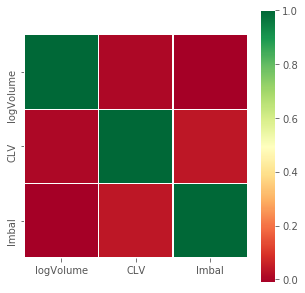

In [20]:
def visualize_data_sns(df):
    df_corr = df.corr()
    f, ax = plt.subplots(figsize=(5, 5))

    sns.heatmap(df_corr, square=True, linewidths=0.2, cmap='RdYlGn', ax=ax)
    plt.savefig('corr.png', dpi=100)
    plt.show()
    
visualize_data_sns(S_train[['logVolume','CLV', 'Imbal']])

## - Min Data

### 1. Distribution of each features

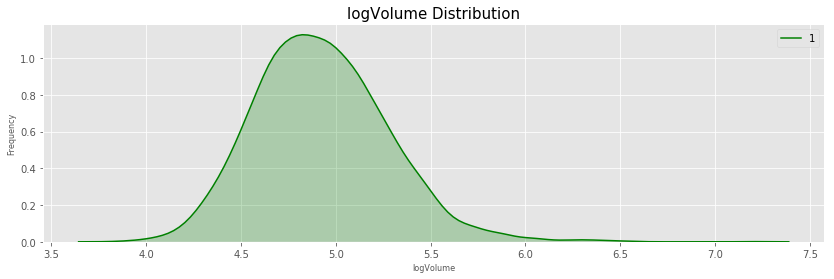

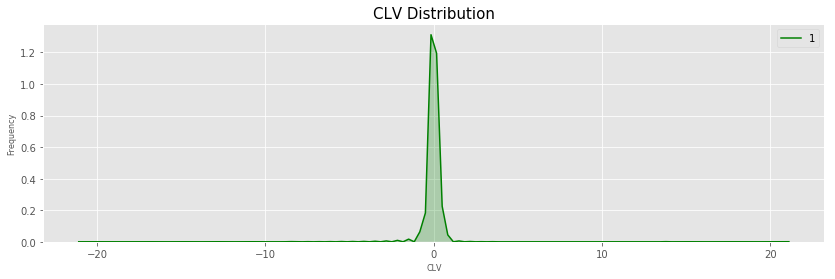

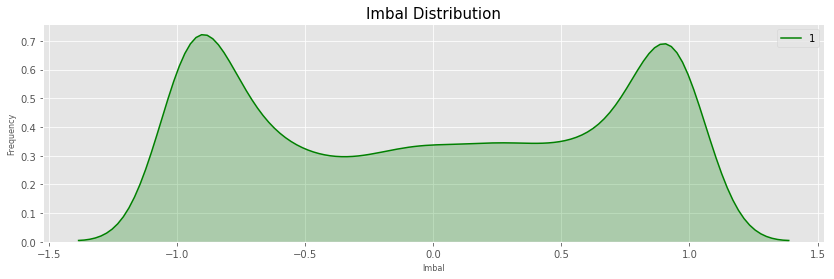

In [21]:
for col in ['logVolume','CLV', 'Imbal']:
    fig = plt.figure(figsize=(14,4));
    ax=sns.kdeplot(M_train.loc[:,col] , color='g',shade=True,label='1');
    plt.title(col+' Distribution', fontsize = 15);
    plt.ylabel("Frequency", fontsize = 8);
    plt.xlabel(col, fontsize = 8);

### 2. Distribution of fwdRet1Bps and pxDir1

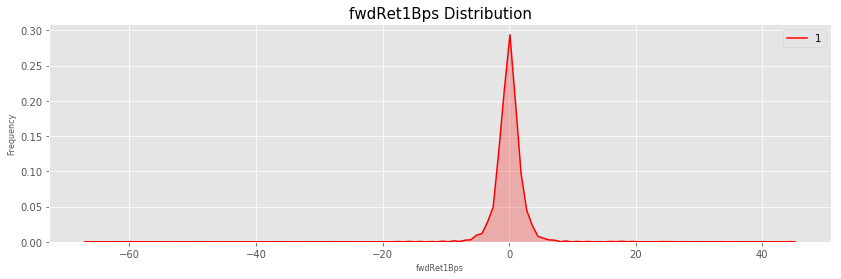

In [22]:
fig = plt.figure(figsize=(14,4));
ax=sns.kdeplot(M_train.loc[:,'fwdRet1Bps'] , color='r',shade=True,label='1');
plt.title('fwdRet1Bps'+' Distribution', fontsize = 15);
plt.ylabel("Frequency", fontsize = 8);
plt.xlabel('fwdRet1Bps', fontsize = 8);

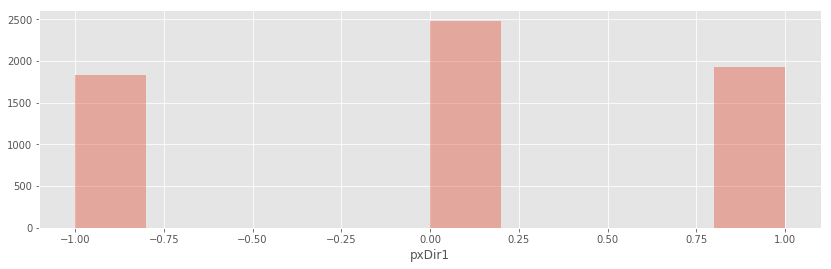

In [23]:
plt.figure(figsize=(14,4))
sns.distplot(M_train.pxDir1.astype(int),kde=False)

### 3. Feature distributions with different labels

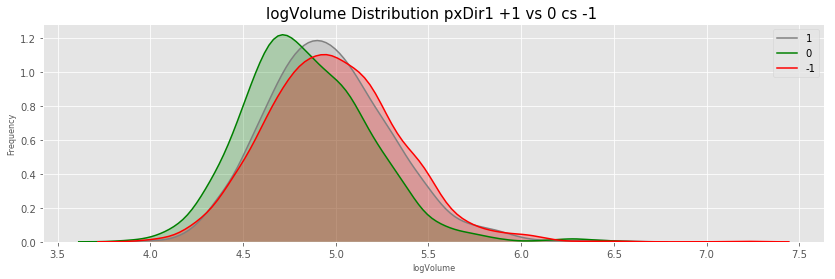

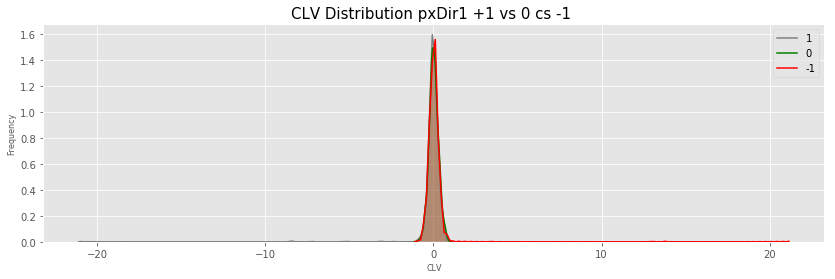

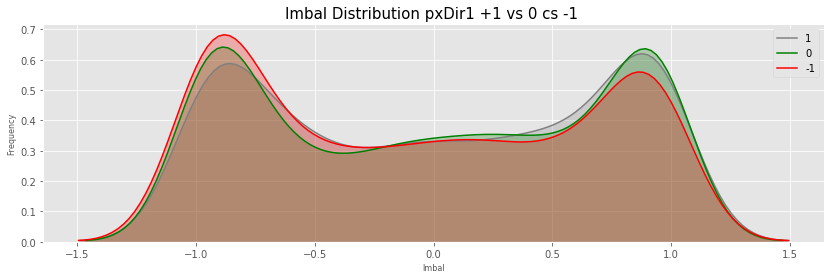

In [24]:
import seaborn as sns

for col in ['logVolume', 'CLV', 'Imbal']:
    fig = plt.figure(figsize=(14,4));
    ax=sns.kdeplot(M_train.loc[(M_train['pxDir1'] == '1'),col] , color='gray',shade=True,label='1');
    ax=sns.kdeplot(M_train.loc[(M_train['pxDir1'] == '0'),col] , color='g',shade=True, label='0');
    ax=sns.kdeplot(M_train.loc[(M_train['pxDir1'] == '-1'),col] , color='r',shade=True, label='-1')
    plt.title(col+' Distribution pxDir1 +1 vs 0 cs -1 ', fontsize = 15);
    plt.ylabel("Frequency", fontsize = 8);
    plt.xlabel(col, fontsize = 8);

### 4. Correlation heat map

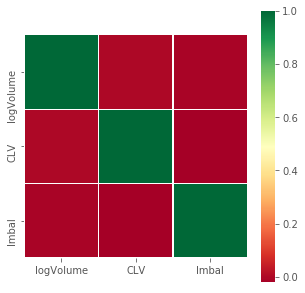

In [26]:
visualize_data_sns(M_train[['logVolume','CLV', 'Imbal']])



#  <font color="#0000dd"> Model Building </font> <br/>   

## Baseline model

- The baseline model predicts the price direction class  𝐶={−1,0,1} randomly using the class empirical probability of occurence.
- Estimate the empirical probabilities of the baseline model using the training set.
- Make predictions for pxDir1 (simply sample the multinomial distribution) and use the testing set to report

A function to measure model preformance ( confusion matrix and report ) :

In [36]:
def report(y,y_pred,modelname):
    cmb=confusion_matrix(y,y_pred)
    plt.figure()
    sns.heatmap(cmb, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = str(modelname) +" Model \n accuracy score {0}".format(round(accuracy_score(y,y_pred),3))
    plt.title(all_sample_title, size = 15);

    Accuraccy=accuracy_score(y,y_pred)
    Precision=precision_score(y,y_pred,average='weighted')
    Recall=recall_score(y,y_pred,average='weighted')
    F1wght=f1_score(y,y_pred, average="weighted")
    F1micro=f1_score(y,y_pred, average="micro")
    report=pd.DataFrame({'Model':[modelname],'Accuracy':[Accuraccy], 'Precision':[Precision],'Recall':[Recall],'F1wght':[F1wght],'F1micro':[F1micro]})
    report
    
    return report
    

### - Sec Data

In [37]:
rate_p1=len(S_train[S_train.pxDir1=='1'])/len(S_train)
rate_0=len(S_train[S_train.pxDir1=='0'])/len(S_train)
rate_n1=len(S_train[S_train.pxDir1=='-1'])/len(S_train)

In [38]:
print(rate_p1,rate_0,rate_n1)

0.12244679427118191 0.7553473430598313 0.12220586266898675


In [39]:
import random
Baseline_train=random.choices(population=['1', '0', '-1'],weights=[rate_p1, rate_0, rate_n1],k=len(S_train))
Baseline_test=random.choices(population=['1', '0', '-1'],weights=[rate_p1, rate_0, rate_n1],k=len(S_test))

,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,Baseline,0.439136,0.379505,0.439136,0.385197,0.439136


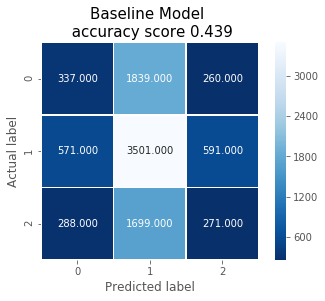

In [230]:
S0=report(S_test.pxDir1,Baseline_test,'Baseline')
S0

### - Min Data

In [33]:
rate_p1_M=len(M_train[M_train.pxDir1=='1'])/len(M_train)
rate_0_M=len(M_train[M_train.pxDir1=='0'])/len(M_train)
rate_n1_M=len(M_train[M_train.pxDir1=='-1'])/len(M_train)

In [34]:
Baseline_train_M=random.choices(population=['1', '0', '-1'],weights=[rate_p1_M, rate_0_M, rate_n1_M],k=len(M_train))
Baseline_test_M=random.choices(population=['1', '0', '-1'],weights=[rate_p1_M, rate_0_M, rate_n1_M],k=len(M_test))

,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,Baseline,0.328205,0.356264,0.328205,0.330714,0.328205


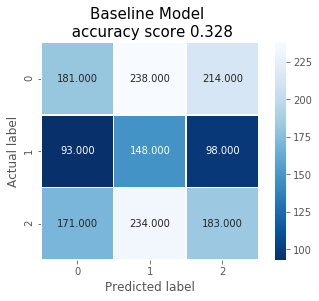

In [231]:
M0=report(M_test.pxDir1,Baseline_test_M,'Baseline')
M0

## LogisticRegression

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model, preprocessing, model_selection 
from sklearn.model_selection import StratifiedKFold

logistic_clf = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')

logistic_clf.fit(S_train_X, S_train_y)

S_train_y_p= logistic_clf.predict(S_train_X)
S_test_y_p = logistic_clf.predict(S_test_X)

,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,LogisticRegression,0.500053,0.490768,0.500053,0.338111,0.500053


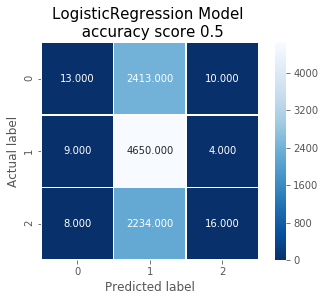

In [149]:
S1=report(S_test.pxDir1,S_test_y_p,'LogisticRegression')
S1

- GridSearch (but nothing improved here)

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# C_vals is the alpla value of lasso and ridge regression(as alpha increases the model complexity decreases,)
# effective alpha scores are 0<alpha<infinity 
C_vals = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,12,13,14,15,20]
# Choosing penalties
penalties = ['l2']
# Choose a cross validation strategy. 
cv = StratifiedShuffleSplit(n_splits = 10, test_size = .25)
# setting param for param_grid in GridSearchCV. 
param = {'penalty': penalties, 'C': C_vals}
# Calling on GridSearchCV object. 
grid = GridSearchCV(estimator=linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg'), 
                           param_grid = param,
                           scoring = 'accuracy',
                            n_jobs =-1,
                           cv = cv
                          )
grid.fit(S_train_X, S_train_y)



GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.25,
            train_size=None),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l2'], 'C': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,LogisticRegression,0.500053,0.490768,0.500053,0.338111,0.500053


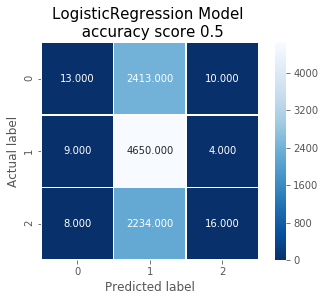

In [44]:
S_test_y_p = grid.predict(S_test_X)
report(S_test.pxDir1,S_test_y_p,'LogisticRegression')

### - Min Data

In [45]:
logistic_clf.fit(M_train_X, M_train_y)
M_test_y_p = logistic_clf.predict(M_test_X)

,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,LogisticRegression,0.357692,0.391041,0.357692,0.355455,0.357692


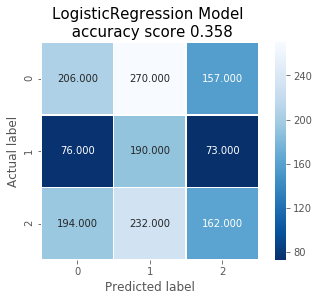

In [150]:
M1=report(M_test_y,M_test_y_p,'LogisticRegression')
M1

##  XGBClassifier model

In [157]:
from xgboost import XGBClassifier
XGBClassifier = XGBClassifier(learning_rate =0.01,n_estimators=50,max_depth = 5)
XGBClassifier.fit(S_train_X, S_train_y)
XGB_y_pred = XGBClassifier.predict(S_test_X)
XGBClassifier_accy = round(accuracy_score(S_test.pxDir1, XGB_y_pred ), 3)
XGBClassifiertrain=round(accuracy_score(S_train_y,XGBClassifier.predict(S_train_X)), 3)
print ("Accuracy train : %.3f [%s]" %(XGBClassifiertrain,   "XGBClassifier"))
print ("Accuracy test : %.3f [%s]" %(XGBClassifier_accy,   "XGBClassifier"))

Accuracy train : 0.757 [XGBClassifier]
Accuracy test : 0.499 [XGBClassifier]


### - Sec Data

,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,XGBClassifier,0.498878,0.427537,0.498878,0.337476,0.498878


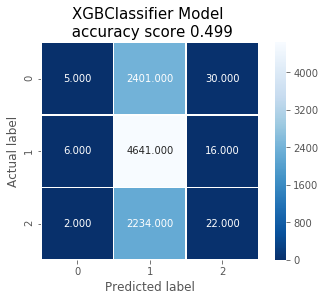

In [158]:
S2=report(S_test.pxDir1,XGB_y_pred,'XGBClassifier')
S2

### - Min Data

,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,XGBClassifier,0.355128,0.390337,0.355128,0.351229,0.355128


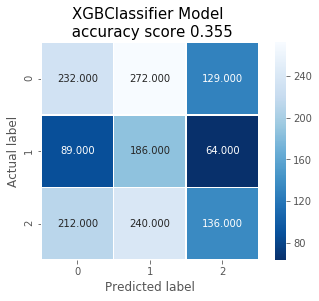

In [160]:
from xgboost import XGBClassifier
XGBClassifier = XGBClassifier(learning_rate =0.01,n_estimators=50,max_depth = 5)
XGBClassifier.fit(M_train_X, M_train_y)
XGB_y_pred_M = XGBClassifier.predict(M_test_X)
M2=report(M_test.pxDir1,XGB_y_pred_M,'XGBClassifier')
M2

## LSTM

### - Sec Data
### Prepare data for RNN model

In [166]:
lstm_data_X=S_data[['logVolume','CLV', 'Imbal']]

In [167]:
from keras.utils import to_categorical
n_classes=3
lstm_data_y=to_categorical(S_data['pxDir1'], n_classes)

A function of data preparing for multivariate time series forecasting, which allow us to choose different timesteps as inputs for RNN model :

In [168]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [264]:
S_data_lstm=lstm_data_X
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_S = scaler.fit_transform(S_data_lstm)
# frame as supervised learning
S_data_reframed = series_to_supervised(scaled_S, 5, 1)
#S_data_reframed.drop(S_data_reframed.columns[list(range(3,51,4))], axis=1, inplace=True)
S_data_reframed.head()

,var1(t-5),var2(t-5),var3(t-5),var1(t-4),var2(t-4),var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
5,0.639168,0.233607,0.200294,0.617111,0.565573,0.173756,0.538116,0.416165,0.626768,0.557698,0.472734,0.150448,0.611792,0.524912,0.950255,0.552808,0.602204,0.501334
6,0.617111,0.565573,0.173756,0.538116,0.416165,0.626768,0.557698,0.472734,0.150448,0.611792,0.524912,0.950255,0.552808,0.602204,0.501334,0.522352,0.229508,0.049773
7,0.538116,0.416165,0.626768,0.557698,0.472734,0.150448,0.611792,0.524912,0.950255,0.552808,0.602204,0.501334,0.522352,0.229508,0.049773,0.614848,0.346247,0.019276
8,0.557698,0.472734,0.150448,0.611792,0.524912,0.950255,0.552808,0.602204,0.501334,0.522352,0.229508,0.049773,0.614848,0.346247,0.019276,0.575868,0.514407,0.955284
9,0.611792,0.524912,0.950255,0.552808,0.602204,0.501334,0.522352,0.229508,0.049773,0.614848,0.346247,0.019276,0.575868,0.514407,0.955284,0.599490,0.537891,0.007893


In [265]:
# Split into train and test
values = S_data_reframed.values
n_test_len = 9357-1
train_X = values[:-n_test_len, :]
test_X = values[-n_test_len:, :]
# Split into X and y
train_y = lstm_data_y[5:-n_test_len]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1]))
test_y = lstm_data_y[-n_test_len:]
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1]))
# Reshape to 3D  [samples, time step, features]
train_X = train_X.reshape((train_X.shape[0], 6, 3))
test_X = test_X.reshape((test_X.shape[0], 6, 3))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(37340, 6, 3) (37340, 3) (9356, 6, 3) (9356, 3)


### Build an RNN model with 2 LSTM cells,  with input of 6 timesteps (1 minute data) each time.

In [266]:
rnn_drop_rate=0.2
rnn = Sequential()
rnn.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]),activation='relu',return_sequences=True,dropout=rnn_drop_rate))
rnn.add(LSTM(units=100,activation='relu',dropout=rnn_drop_rate))            
rnn.add(Dense(3, activation='softmax'))
rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 6, 100)            41600     
_________________________________________________________________
lstm_50 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 303       
Total params: 122,303
Trainable params: 122,303
Non-trainable params: 0
_________________________________________________________________


In [267]:
batch_size=500
epochs=100
val_split=0.1

rnn_es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, mode='auto', baseline=None, restore_best_weights=False)
rnn_history = rnn.fit(train_X ,train_y, batch_size=batch_size, epochs=epochs, validation_split=val_split, callbacks=[rnn_es], verbose=1)

Train on 33606 samples, validate on 3734 samples
Epoch 1/100
33606/33606 [==============================] - 31s 923us/step - loss: 0.8003 - acc: 0.7463 - val_loss: 0.7538 - val_acc: 0.7402
Epoch 2/100
33606/33606 [==============================] - 14s 409us/step - loss: 0.7243 - acc: 0.7572 - val_loss: 0.7495 - val_acc: 0.7402
Epoch 3/100
33606/33606 [==============================] - 14s 421us/step - loss: 0.7225 - acc: 0.7572 - val_loss: 0.7510 - val_acc: 0.7402
Epoch 4/100
33606/33606 [==============================] - 12s 348us/step - loss: 0.7210 - acc: 0.7572 - val_loss: 0.7473 - val_acc: 0.7402
Epoch 5/100
33606/33606 [==============================] - 13s 373us/step - loss: 0.7199 - acc: 0.7572 - val_loss: 0.7504 - val_acc: 0.7402
Epoch 6/100
33606/33606 [==============================] - 12s 353us/step - loss: 0.7209 - acc: 0.7572 - val_loss: 0.7443 - val_acc: 0.7402
Epoch 7/100
33606/33606 [==============================] - 13s 376us/step - loss: 0.7157 - acc: 0.7572 - val_lo

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,LSTM,0.49829,0.248293,0.49829,0.331435,0.49829


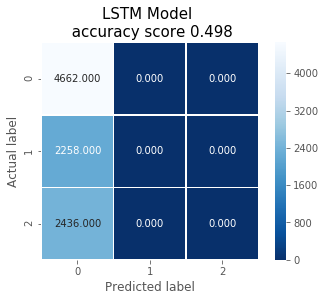

In [268]:
yhat = rnn.predict(test_X)
a=np.argmax(yhat, axis=1) 
b=np.argmax(test_y, axis=1) 
S3=report(b,a,'LSTM')
S3

- Because of imbalanced data, LSTM have a very poor performace here. Which is making all predictions as the majority label in the training set.

### - Min Data
### Prepare data for RNN model

In [255]:
lstm_data_X_M=M_data[['logVolume','CLV', 'Imbal']]
n_classes=3
lstm_data_y_M=to_categorical(M_data['pxDir1'], n_classes)

In [256]:
lstm_data_y_M.shape

(7792, 3)

In [257]:
M_data_lstm=lstm_data_X_M
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_M = scaler.fit_transform(M_data_lstm)
# frame as supervised learning
M_data_reframed = series_to_supervised(scaled_M, 2, 1)
#S_data_reframed.drop(S_data_reframed.columns[list(range(3,51,4))], axis=1, inplace=True)
M_data_reframed.head()

,var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
2,0.380643,0.470064,0.092151,0.413080,0.470745,0.282957,0.439729,0.470246,0.094498
3,0.413080,0.470745,0.282957,0.439729,0.470246,0.094498,0.414187,0.473182,0.141694
4,0.439729,0.470246,0.094498,0.414187,0.473182,0.141694,0.422835,0.472578,0.196396
5,0.414187,0.473182,0.141694,0.422835,0.472578,0.196396,0.367209,0.465923,0.218838
6,0.422835,0.472578,0.196396,0.367209,0.465923,0.218838,0.408506,0.467602,0.196396


In [258]:
len(M_data_lstm[M_data_lstm.index > np.datetime64('2018-06-23')])

1560

In [273]:
# Split into train and test
values = M_data_reframed.values
m_test_len = 1560-1
train_X_M = values[:-m_test_len, :]
test_X_M = values[-m_test_len:, :]
# Split into X and y
train_y_M = lstm_data_y_M[2:-m_test_len]
train_y_M = train_y_M.reshape((train_y_M.shape[0], train_y_M.shape[1]))
test_y_M = lstm_data_y_M[-m_test_len:]
test_y_M= test_y_M.reshape((test_y_M.shape[0], test_y_M.shape[1]))
# Reshape to 3D  [samples, time step, features]
train_X_M = train_X_M.reshape((train_X_M.shape[0], 3, 3))
test_X_M = test_X_M.reshape((test_X_M.shape[0],3, 3))
print(train_X_M.shape, train_y_M.shape, test_X_M.shape, test_y_M.shape)

(6231, 3, 3) (6231, 3) (1559, 3, 3) (1559, 3)


### Build an RNN model with 2 LSTM cells,  with input of 3 timesteps (3 minute data) each time.

In [274]:
rnn_drop_rate=0.2
rnn = Sequential()
rnn.add(LSTM(60, input_shape=(train_X_M.shape[1], train_X_M.shape[2]),activation='relu',return_sequences=True,dropout=rnn_drop_rate))
rnn.add(LSTM(units=60,activation='relu',dropout=rnn_drop_rate))            
rnn.add(Dense(3, activation='softmax'))
rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 3, 60)             15360     
_________________________________________________________________
lstm_54 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 183       
Total params: 44,583
Trainable params: 44,583
Non-trainable params: 0
_________________________________________________________________


In [276]:
batch_size=100
epochs=100
val_split=0.1
rnn2_es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, mode='auto', baseline=None, restore_best_weights=False)
rnn2_history = rnn.fit(train_X_M ,train_y_M, batch_size=batch_size, epochs=epochs, validation_split=val_split, callbacks=[rnn2_es], verbose=1)

Train on 5607 samples, validate on 624 samples
Epoch 1/100
5607/5607 [==============================] - 2s 330us/step - loss: 1.0886 - acc: 0.4011 - val_loss: 1.0936 - val_acc: 0.3734
Epoch 2/100
5607/5607 [==============================] - 2s 312us/step - loss: 1.0879 - acc: 0.4011 - val_loss: 1.0948 - val_acc: 0.3734
Epoch 3/100
5607/5607 [==============================] - 2s 345us/step - loss: 1.0868 - acc: 0.4011 - val_loss: 1.0928 - val_acc: 0.3734
Epoch 4/100
5607/5607 [==============================] - 2s 312us/step - loss: 1.0863 - acc: 0.4011 - val_loss: 1.0896 - val_acc: 0.3734
Epoch 5/100
5607/5607 [==============================] - 2s 309us/step - loss: 1.0857 - acc: 0.4015 - val_loss: 1.0919 - val_acc: 0.3734
Epoch 6/100
5607/5607 [==============================] - 2s 329us/step - loss: 1.0831 - acc: 0.4004 - val_loss: 1.0924 - val_acc: 0.3734
Epoch 7/100
5607/5607 [==============================] - 2s 350us/step - loss: 1.0839 - acc: 0.4061 - val_loss: 1.0908 - val_acc: 0

In [277]:
yhat_M = rnn.predict(test_X_M )
yhat_M 
a_M =np.argmax(yhat_M , axis=1) 
b_M =np.argmax(test_y_M , axis=1) 
b_M ,a_M 

(array([2, 1, 1, ..., 2, 1, 2]), array([1, 0, 0, ..., 0, 0, 0]))

,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,LSTM,0.224503,0.425898,0.224503,0.095854,0.224503


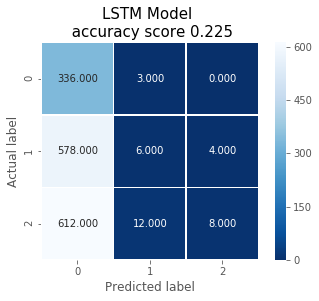

In [278]:
M3=report(b_M ,a_M ,'LSTM')
M3


#  <table><tr><td bgcolor=orange> <font  color=#4B0082 size=5> Improvement  </font> </td></tr></table>

## - SEC Data

### Create new features:
- Here I create several new features of high and low price, because our original features are all 
- Moving average value of highPx, lowPx, difference between highPx lowPx and the average of highPx lowPx.

In [105]:
S_data['MA_HPx']=S_data['highPx'].rolling(12).mean()
S_data['MA_LPx']=S_data['lowPx'].rolling(12).mean()
S_data['MA_Pxdiff']=(S_data['highPx']-S_data['lowPx']).rolling(12).mean()
S_data['MA_Px']=0.5*(S_data['highPx']+S_data['lowPx']).rolling(12).mean()

In [106]:
S_data_imp=S_data[['logVolume','CLV', 'Imbal','MA_HPx','MA_LPx','MA_Pxdiff', 'MA_Px','pxDir1']]
S_data_imp=S_data_imp.dropna()
S_data_imp.head()

,logVolume,CLV,Imbal,MA_HPx,MA_LPx,MA_Pxdiff,MA_Px,pxDir1
T,,,,,,,,
2018-06-01 09:31:50,5.033990,-0.622126,-0.600000,272.491806,272.413338,0.078468,272.452572,1
2018-06-01 09:32:00,4.901823,0.119882,-0.652893,272.496198,272.428337,0.067861,272.462268,-1
2018-06-01 09:32:10,4.428491,-0.214074,0.250000,272.499532,272.439171,0.060361,272.469351,1
2018-06-01 09:32:20,4.545826,-0.087632,-0.699346,272.507449,272.447502,0.059947,272.477475,0
2018-06-01 09:32:30,4.869953,0.028996,0.894737,272.514949,272.452502,0.062447,272.483725,0


In [107]:
S_train_I=S_data_imp[S_data_imp.index< '2018-06-23']
S_test_I=S_data_imp[S_data_imp.index > '2018-06-23']

S_train_IX=S_train_I.iloc[:,:-1]
S_train_Iy=S_train_I.iloc[:,-1]
S_test_IX=S_test_I.iloc[:,:-1]
S_test_Iy=S_test_I.iloc[:,-1]

###   Feature selection

 ### - Benefits:
    - Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
    - Improves Accuracy: Less misleading data means modeling accuracy improves.
    - Reduces Training Time: Less data means that algorithms train faste
 ### - What I do:
    - Using Extra Trees to estimate the importance of features.
    - The model gives an importance score for each attribute, the larger score the more important the attribute.
    - Choose the most important one among the new features as out new feature for improvement.

[0.15934851 0.14365363 0.13412449 0.13270408 0.1321088  0.16635769
 0.1317028 ]


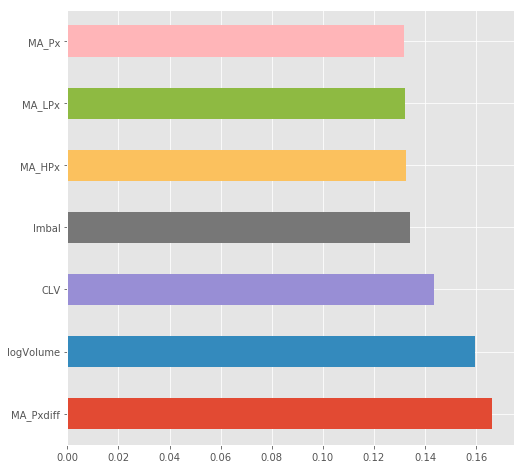

In [108]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(criterion='entropy')
model.fit(S_train_IX, S_train_Iy)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
fig = plt.figure(figsize=(8,8))
feat_importances = pd.Series(model.feature_importances_, index=S_train_IX.columns)
feat_importances.nlargest(len(S_train_IX.columns)).plot(kind='barh')
plt.show()

In [109]:
S_train_IX=S_train_I[['logVolume','CLV', 'Imbal','MA_Pxdiff']]
S_train_Iy=S_train_I.iloc[:,-1]
S_test_IX=S_test_I[['logVolume','CLV', 'Imbal','MA_Pxdiff']]
S_test_Iy=S_test_I.iloc[:,-1]

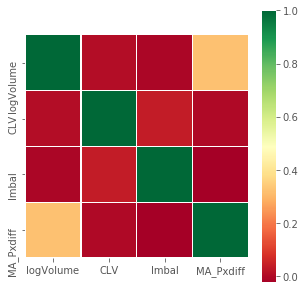

In [110]:
visualize_data_sns(S_train_IX)

###  Model building

In [111]:
logistic_clf = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
logistic_clf.fit(S_train_IX, S_train_Iy)
S_test_Iy_p = logistic_clf.predict(S_train_IX)

,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,LogisticRegression(Newfeature),0.755222,0.6624,0.755222,0.657725,0.755222


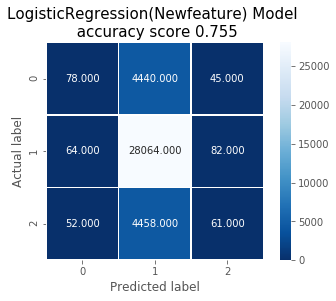

In [204]:
S4=report(S_train_Iy,S_test_Iy_p,'LogisticRegression(Newfeature)')
S4

,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,XGBClassifier(Newfeature),0.758408,0.707024,0.758408,0.661155,0.758408


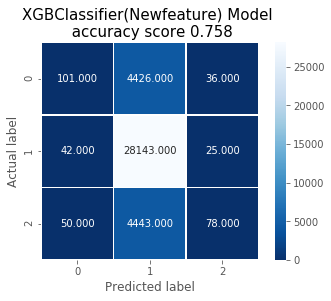

In [205]:
from xgboost import XGBClassifier
XGBClassifier2 = XGBClassifier()
XGBClassifier2.fit(S_train_IX, S_train_Iy)
XGB_Iy_p = XGBClassifier2.predict(S_train_IX)
S5=report(S_train_Iy,XGB_Iy_p,'XGBClassifier(Newfeature)')
S5

In [248]:
S_data=S_data.dropna()
lstm_data_XI=S_data[['logVolume','CLV', 'Imbal','MA_Pxdiff']]
n_classes=3
lstm_data_yI=to_categorical(S_data['pxDir1'], n_classes)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_SI = scaler.fit_transform(lstm_data_XI)
# frame as supervised learning
SI_data_reframed = series_to_supervised(scaled_SI, 5, 1)
SI_data_reframed.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),...,var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
5,0.639168,0.233607,0.200294,0.082675,0.617111,0.565573,0.173756,0.070110,0.538116,0.416165,...,0.150448,0.060734,0.611792,0.524912,0.950255,0.063696,0.552808,0.602204,0.501334,0.061720
6,0.617111,0.565573,0.173756,0.070110,0.538116,0.416165,0.626768,0.061225,0.557698,0.472734,...,0.950255,0.063696,0.552808,0.602204,0.501334,0.061720,0.522352,0.229508,0.049773,0.066163
7,0.538116,0.416165,0.626768,0.061225,0.557698,0.472734,0.150448,0.060734,0.611792,0.524912,...,0.501334,0.061720,0.522352,0.229508,0.049773,0.066163,0.614848,0.346247,0.019276,0.062711
8,0.557698,0.472734,0.150448,0.060734,0.611792,0.524912,0.950255,0.063696,0.552808,0.602204,...,0.049773,0.066163,0.614848,0.346247,0.019276,0.062711,0.575868,0.514407,0.955284,0.061726
9,0.611792,0.524912,0.950255,0.063696,0.552808,0.602204,0.501334,0.061720,0.522352,0.229508,...,0.019276,0.062711,0.575868,0.514407,0.955284,0.061726,0.599490,0.537891,0.007893,0.063554


In [249]:
len(S_data[S_data.index > np.datetime64('2018-06-23')])

9357

In [250]:
# Split into train and test
values = SI_data_reframed.values
n_test_len = 9357-1
train_X = values[:-n_test_len, :]
test_X = values[-n_test_len:, :]
# Split into X and y
train_y = lstm_data_yI[5:-n_test_len]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1]))
test_y = lstm_data_yI[-n_test_len:]
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1]))
# Reshape to 3D  [samples, time step, features]
train_X = train_X.reshape((train_X.shape[0], 6, 4))
test_X = test_X.reshape((test_X.shape[0], 6, 4))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(37340, 6, 4) (37340, 3) (9356, 6, 4) (9356, 3)


In [251]:
rnn_drop_rate=0.2
rnn = Sequential()
rnn.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]),activation='relu',return_sequences=True,dropout=rnn_drop_rate))
rnn.add(LSTM(units=100,activation='relu',dropout=rnn_drop_rate))            
rnn.add(Dense(3, activation='softmax'))
rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 6, 100)            42000     
_________________________________________________________________
lstm_46 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 303       
Total params: 122,703
Trainable params: 122,703
Non-trainable params: 0
_________________________________________________________________


In [252]:
batch_size=1000
epochs=100
val_split=0.1

rnn_es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, mode='auto', baseline=None, restore_best_weights=False)
rnn_history = rnn.fit(train_X ,train_y, batch_size=batch_size, epochs=epochs, validation_split=val_split, callbacks=[rnn_es], verbose=1)

Train on 33606 samples, validate on 3734 samples
Epoch 1/100
33606/33606 [==============================] - 26s 773us/step - loss: 0.8648 - acc: 0.7378 - val_loss: 0.7738 - val_acc: 0.7402
Epoch 2/100
33606/33606 [==============================] - 11s 338us/step - loss: 0.7342 - acc: 0.7572 - val_loss: 0.7529 - val_acc: 0.7402
Epoch 3/100
33606/33606 [==============================] - 12s 361us/step - loss: 0.7228 - acc: 0.7572 - val_loss: 0.7455 - val_acc: 0.7402
Epoch 4/100
33606/33606 [==============================] - 13s 399us/step - loss: 0.7185 - acc: 0.7572 - val_loss: 0.7417 - val_acc: 0.7402
Epoch 5/100
33606/33606 [==============================] - 13s 373us/step - loss: 0.7140 - acc: 0.7572 - val_loss: 0.7352 - val_acc: 0.7402
Epoch 6/100
33606/33606 [==============================] - 11s 316us/step - loss: 0.7115 - acc: 0.7572 - val_loss: 0.7265 - val_acc: 0.7402
Epoch 7/100
33606/33606 [==============================] - 11s 316us/step - loss: 0.7051 - acc: 0.7572 - val_lo

In [253]:
yhat = rnn.predict(test_X)
a=np.argmax(yhat , axis=1) 
b=np.argmax(test_y , axis=1) 

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,LSTM(Newfeature),0.49829,0.248293,0.49829,0.331435,0.49829


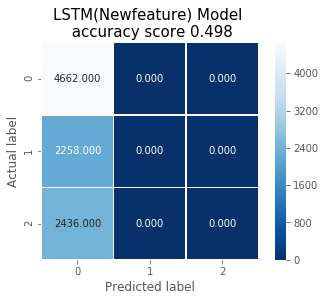

In [254]:
S6=report(b,a,'LSTM(Newfeature)')
S6

## - MIN Data

### Create new features:
- Here I create several new features of high and low price, because our original features are all 
- Moving average value of highPx, lowPx, difference between highPx lowPx and the average of highPx lowPx.

In [195]:
M_data['MA_HPx']=M_data['highPx'].rolling(5).mean()
M_data['MA_LPx']=M_data['lowPx'].rolling(5).mean()
M_data['MA_Pxdiff']=(M_data['highPx']-M_data['lowPx']).rolling(5).mean()
M_data['MA_Px']=0.5*(M_data['highPx']+M_data['lowPx']).rolling(5).mean()

M_data_imp=M_data[['logVolume','CLV', 'Imbal','MA_HPx','MA_LPx','MA_Pxdiff', 'MA_Px','pxDir1']]
M_data_imp=M_data_imp.dropna()
M_data_imp.head()


M_train_I=M_data_imp[M_data_imp.index < '2018-06-23']
M_test_I=M_data_imp[M_data_imp.index > '2018-06-23']

M_train_IX=M_train_I.iloc[:,:-1]
M_train_Iy=M_train_I.iloc[:,-1]
M_test_IX=M_test_I.iloc[:,:-1]
M_test_Iy=M_test_I.iloc[:,-1]


###   Feature selection

[0.15025921 0.14296828 0.13982279 0.13831586 0.13801597 0.15367268
 0.13694521]


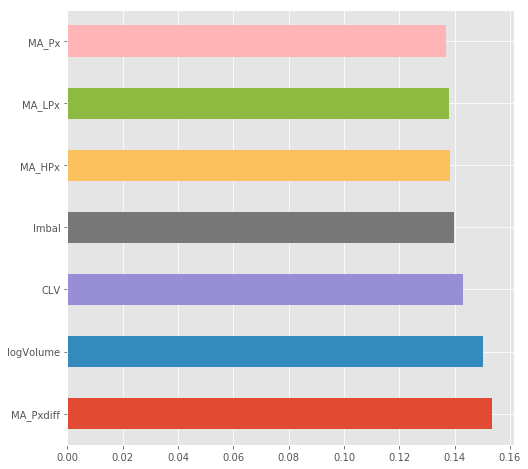

In [125]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(criterion='entropy')
model.fit(M_train_IX, M_train_Iy)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
fig = plt.figure(figsize=(8,8))
feat_importances = pd.Series(model.feature_importances_, index=M_train_IX.columns)
feat_importances.nlargest(len(M_train_IX.columns)).plot(kind='barh')
plt.show()

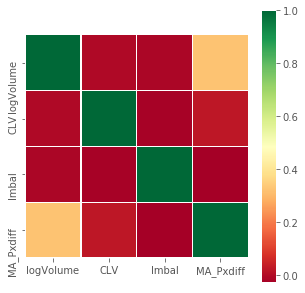

In [126]:
M_train_IX=M_train_I[['logVolume','CLV', 'Imbal','MA_Pxdiff']]
M_train_Iy=M_train_I.iloc[:,-1]
M_test_IX=M_test_I[['logVolume','CLV', 'Imbal','MA_Pxdiff']]
M_test_Iy=M_test_I.iloc[:,-1]

visualize_data_sns(M_train_IX)

###  Model building

/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,LogisticRegression(Newfeature),0.43389,0.413212,0.43389,0.386455,0.43389


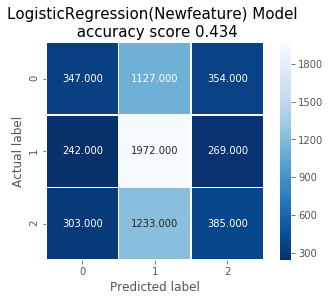

In [214]:
logistic_clf = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
logistic_clf.fit(M_train_IX, M_train_Iy)
M_test_Iy_p = logistic_clf.predict(M_train_IX)

M4=report(M_train_Iy,M_test_Iy_p,'LogisticRegression(Newfeature)')
M4

,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,XGBClassifier(Newfeature),0.511553,0.511392,0.511553,0.488462,0.511553


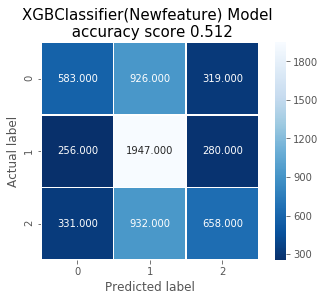

In [215]:
from xgboost import XGBClassifier
XGBClassifier2 = XGBClassifier()
XGBClassifier2.fit(M_train_IX, M_train_Iy)
XGB_IMy_p = XGBClassifier2.predict(M_train_IX)
M5=report(M_train_Iy,XGB_IMy_p,'XGBClassifier(Newfeature)')
M5

In [219]:
M_data=M_data.dropna()
lstm_data_XIM=M_data[['logVolume','CLV', 'Imbal','MA_Pxdiff']]
n_classes=3
lstm_data_yI=to_categorical(M_data['pxDir1'], n_classes)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_MI = scaler.fit_transform(lstm_data_XIM)
# frame as supervised learning
MI_data_reframed = series_to_supervised(scaled_MI, 2, 1)
MI_data_reframed.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
2,0.380643,0.470064,0.092151,0.073661,0.413080,0.470745,0.282957,0.067762,0.439729,0.470246,0.094498,0.044040
3,0.413080,0.470745,0.282957,0.067762,0.439729,0.470246,0.094498,0.044040,0.414187,0.473182,0.141694,0.036479
4,0.439729,0.470246,0.094498,0.044040,0.414187,0.473182,0.141694,0.036479,0.422835,0.472578,0.196396,0.037466
5,0.414187,0.473182,0.141694,0.036479,0.422835,0.472578,0.196396,0.037466,0.367209,0.465923,0.218838,0.035402
6,0.422835,0.472578,0.196396,0.037466,0.367209,0.465923,0.218838,0.035402,0.408506,0.467602,0.196396,0.041301


In [220]:
len(M_data[M_data.index > np.datetime64('2018-06-23')])

1560

In [234]:
# Split into train and test
values = MI_data_reframed.values
n_test_len = 1560-1
train_X = values[:-n_test_len, :]
test_X = values[-n_test_len:, :]
# Split into X and y
train_y = lstm_data_yI[2:-n_test_len]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1]))
test_y = lstm_data_yI[-n_test_len:]
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1]))
# Reshape to 3D  [samples, time step, features]
train_X = train_X.reshape((train_X.shape[0], 3, 4))
test_X = test_X.reshape((test_X.shape[0], 3, 4))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6231, 3, 4) (6231, 3) (1559, 3, 4) (1559, 3)


In [235]:
rnn_drop_rate=0.2
rnn = Sequential()
rnn.add(LSTM(60, input_shape=(train_X.shape[1], train_X.shape[2]),activation='relu',return_sequences=True,dropout=rnn_drop_rate))
rnn.add(LSTM(units=60,activation='relu',dropout=rnn_drop_rate))            
rnn.add(Dense(3, activation='softmax'))
rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 3, 60)             15600     
_________________________________________________________________
lstm_40 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 183       
Total params: 44,823
Trainable params: 44,823
Non-trainable params: 0
_________________________________________________________________


In [236]:
batch_size=100
epochs=100
val_split=0.1

rnn_es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, mode='auto', baseline=None, restore_best_weights=False)
rnn_history = rnn.fit(train_X ,train_y, batch_size=batch_size, epochs=epochs, validation_split=val_split, callbacks=[rnn_es], verbose=1)

Train on 5607 samples, validate on 624 samples
Epoch 1/100
5607/5607 [==============================] - 15s 3ms/step - loss: 1.0920 - acc: 0.3995 - val_loss: 1.0970 - val_acc: 0.3734
Epoch 2/100
5607/5607 [==============================] - 2s 305us/step - loss: 1.0885 - acc: 0.4011 - val_loss: 1.0954 - val_acc: 0.3734
Epoch 3/100
5607/5607 [==============================] - 2s 302us/step - loss: 1.0876 - acc: 0.4011 - val_loss: 1.0952 - val_acc: 0.3734
Epoch 4/100
5607/5607 [==============================] - 2s 304us/step - loss: 1.0846 - acc: 0.4015 - val_loss: 1.0893 - val_acc: 0.3750
Epoch 5/100
5607/5607 [==============================] - 2s 301us/step - loss: 1.0868 - acc: 0.4000 - val_loss: 1.0914 - val_acc: 0.3734
Epoch 6/100
5607/5607 [==============================] - 2s 299us/step - loss: 1.0845 - acc: 0.4029 - val_loss: 1.0894 - val_acc: 0.3798
Epoch 7/100
5607/5607 [==============================] - 2s 301us/step - loss: 1.0823 - acc: 0.4139 - val_loss: 1.0851 - val_acc: 0.

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,LSTM(Newfeature),0.34381,0.211025,0.34381,0.259584,0.34381


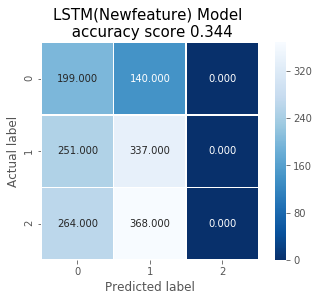

In [237]:
yhat = rnn.predict(test_X)
a=np.argmax(yhat , axis=1) 
b=np.argmax(test_y , axis=1) 
M6=report(b,a,'LSTM(Newfeature)')
M6

#  <table><tr><td bgcolor=orange> <font  color=#4B0082 size=5> Conclusion </font> </td></tr></table>


# <font color="#0000dd"> Summary of model performance </font><br/>   

### - 10 Seconds Data


In [280]:
Second=S0.append(S1).append(S2).append(S3).append(S4).append(S5).append(S6)
Second.set_index(Second['Model'])[['Accuracy','Precision','Recall','F1wght','F1micro']]

,Accuracy,Precision,Recall,F1wght,F1micro
Model,,,,,
Baseline,0.439136,0.379505,0.439136,0.385197,0.439136
LogisticRegression,0.500053,0.490768,0.500053,0.338111,0.500053
XGBClassifier,0.498878,0.427537,0.498878,0.337476,0.498878
LSTM,0.498290,0.248293,0.498290,0.331435,0.498290
LogisticRegression(Newfeature),0.755222,0.662400,0.755222,0.657725,0.755222
XGBClassifier(Newfeature),0.758408,0.707024,0.758408,0.661155,0.758408
LSTM(Newfeature),0.498290,0.248293,0.498290,0.331435,0.498290


### - 1 Minute Data

In [279]:
Minute=M0.append(M1).append(M2).append(M3).append(M4).append(M5).append(M6)
Minute.set_index(Second['Model'])[['Accuracy','Precision','Recall','F1wght','F1micro']]

,Accuracy,Precision,Recall,F1wght,F1micro
Model,,,,,
Baseline,0.328205,0.356264,0.328205,0.330714,0.328205
LogisticRegression,0.357692,0.391041,0.357692,0.355455,0.357692
XGBClassifier,0.355128,0.390337,0.355128,0.351229,0.355128
LSTM,0.224503,0.425898,0.224503,0.095854,0.224503
LogisticRegression(Newfeature),0.433890,0.413212,0.433890,0.386455,0.433890
XGBClassifier(Newfeature),0.511553,0.511392,0.511553,0.488462,0.511553
LSTM(Newfeature),0.343810,0.211025,0.343810,0.259584,0.343810


### Summary:

- LSTM have a very poor performace in this problem, it biased to the majority class '0' in training set, and I think this is because of the imbalanced data set.

- LogisticRegression and XGBClassifier have similar performace in this problem, and they are not seriously influenced by the imbalanced data set.

- Adding moving average value of difference of high and low price has efficiently improved the prediction result.

- Compared with 10 seconds data, 1 minute data have a worse performance, because of less data provide less information to learn from.




# <font color="#0000dd"> Conclusion </font><br/>  




### 1. The importance of data quality and feature engineering : 
  - Compare the accuracy in Minute Data and Second data, we can find model on Second data always have a higher accuracy. 
    
    This is because with more data, models can learn more patterns and thus can perform better at prediction.


  - After adding a new feature related to high and low price directly instead of ratios in original feature, our models' performance improved a lot.
  
  
  - The features will directly influence the predictive models, and highly decide the results we can achieve.
  
  
  - With better features, we could have better results even with simpler model, so we should deal this part seriously.


### 2. How to learn from imbalanced classes :

  - Machine learning classifiers are often biased towards the majority class '0', when we have skewed classification problems. 
  
  
  - Especially the LSTM in our project, it is highly biased towards the majority class '0' because their loss functions attempt to optimize error loss.
  
  
  - I didn't make any improvement to solve imbalanced problem here, because it's hard to say whether accuracy or F1 rate is more important in our project. 
  
  
  - If we face with some problems like Risk Fraud detection, we have to be more careful and apply more sophisticated methods.

### 3. Further Improvement :

   - Learn how to better deal with imbalanced data :
   
      - Oversample the minority class,  Undersample the majority class,  Synthesize new minority classes.
      - Adjust the class weight (misclassification costs) ;  Adjust the decision threshold. 
      - Modify an existing algorithm to be more sensitive to rare classes.


   - Learn how to build better model :  
   
      - Algorithm tuning:  find better parameters for models, like learning rate, solver, penalty method and max   depth. 
        ( I only used gridsearch for logistic here, but it does't have obvious effect. )
        
      - Ensembles: combine the predictions from multiple models  (bagging, stacking).





## ------------------------------------------------------------------------------------------------------------
## The END.
## Thanks !
